In [10]:
import pandas_gbq
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

In [11]:
q='''
SELECT is_discount, is_voucher, is_free_delivery, is_qcommerce, is_corporate, is_commissionable, is_joker, value 
FROM `fulfillment-dwh-production.curated_data_shared_central_dwh.orders` 
where is_sent = true and global_entity_id="FO_NO" and date(placed_at_local) = "2024-01-12"
'''

In [12]:
df = pandas_gbq.read_gbq(q)

Downloading: 100%|██████████|


In [13]:
df.columns

Index(['is_discount', 'is_voucher', 'is_free_delivery', 'is_qcommerce',
       'is_corporate', 'is_commissionable', 'is_joker', 'value'],
      dtype='object')

In [14]:
df['value'][1]

{'commission_base_local': Decimal('0E-9'),
 'commission_base_eur': Decimal('0E-9'),
 'commission_local': Decimal('0E-9'),
 'commission_eur': Decimal('0E-9'),
 'voucher_dh_local': None,
 'voucher_dh_eur': None,
 'voucher_other_local': None,
 'voucher_other_eur': None,
 'discount_dh_local': Decimal('0E-9'),
 'discount_dh_eur': Decimal('0E-9'),
 'discount_other_local': Decimal('258.000000000'),
 'discount_other_eur': Decimal('22.830000000'),
 'joker_customer_discount_local': Decimal('0E-9'),
 'joker_customer_discount_eur': Decimal('0E-9'),
 'delivery_fee_local': Decimal('29.000000000'),
 'delivery_fee_eur': Decimal('2.570000000'),
 'delivery_fee_vat_local': Decimal('3.780000000'),
 'delivery_fee_vat_eur': Decimal('0.330000000'),
 'customer_paid_local': Decimal('639.000000000'),
 'customer_paid_eur': Decimal('56.540000000'),
 'joker_vendor_fee_local': Decimal('0E-9'),
 'joker_vendor_fee_eur': Decimal('0E-9'),
 'gmv_local': Decimal('639.000000000'),
 'gmv_eur': Decimal('56.540000000'),
 'gb

In [15]:
df['incentive_value'] = df['value'].apply(lambda x: x.get('discount_dh_eur', 0) + x.get('discount_other_eur', 0) \
                                          + (0 if x.get('voucher_dh_eur') is None else x.get('voucher_dh_eur')) \
                                          + (0 if x.get('voucher_other_eur') is None else x.get('voucher_other_eur')))

df['basket_value'] = df['value'].apply(lambda x: x.get('service_fee_eur', 0) + x.get('gmv_eur', 0) \
                                       + x.get('delivery_fee_eur', 0) + x.get('delivery_fee_vat_eur', 0) )

In [16]:
def plot_hist(df, subset):
    df_sub = df[df[subset]==True]
    print("Share: %", round(len(df_sub)*100/len(df), 2))
    fig, ax = plt.subplots(figsize = (4,4))
    ax.hist(df_sub['incentive_value'], alpha=0.5, label='incentive_value')
    ax.hist(df_sub['basket_value'], alpha=0.5, label='basket_value')
    ax.legend(loc='upper right')
    plt.show()

def plot_all(df):
    for col in df.columns:
        if "value" not in col:
            print(col)
            plot_hist(df, col)

is_discount
Share: % 29.74


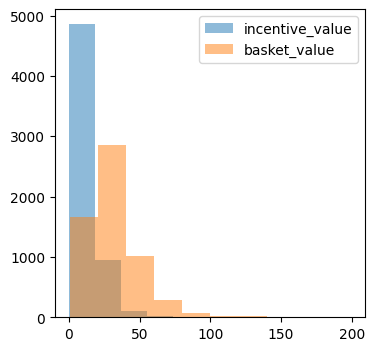

is_voucher
Share: % 5.34


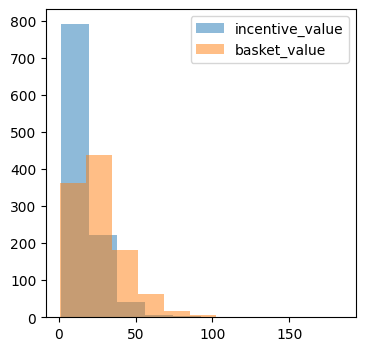

is_free_delivery
Share: % 31.31


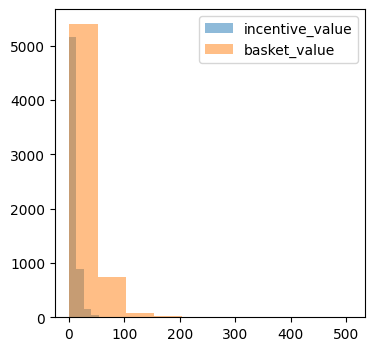

is_qcommerce
Share: % 8.79


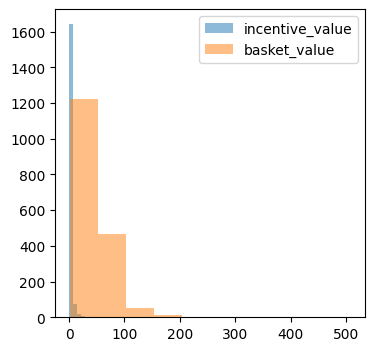

is_corporate
Share: % 0.35


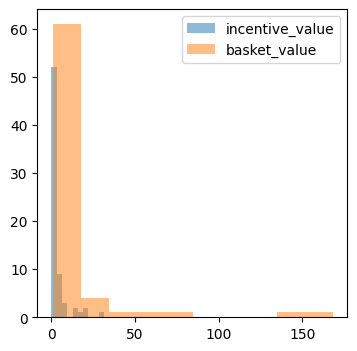

is_commissionable
Share: % 100.0


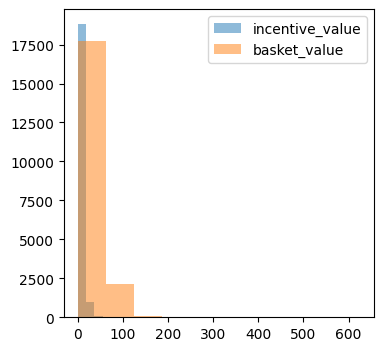

is_joker
Share: % 2.71


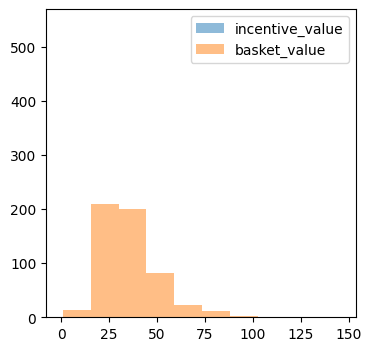

In [17]:
plot_all(df)

In [18]:
df.columns

Index(['is_discount', 'is_voucher', 'is_free_delivery', 'is_qcommerce',
       'is_corporate', 'is_commissionable', 'is_joker', 'value',
       'incentive_value', 'basket_value'],
      dtype='object')

### Columns description:
#### Incentives
- **is_discount**: True if some other discount was given to the customer (other than voucher and joker), e.g. Meal deal / Happy hour / Free drink / Pizza Montag / Free Delivery etc.	
- **is_voucher**: True if a voucher code was used, when the customer types in a code during the order process to receive a price reduction.	
- **is_free_delivery**: True if there was no delivery fee for the order.	
- **is_qcommerce**: True if order was not a food restaurant order.	
- **is_corporate**: True if order is paid between real customer and the company supporting it. For example, DH corporate orders are supported by DH with 6 € per order. It should be true when there is a separate app for other companies to give their employees some kind of benefit.	
- **is_commissionable**: True if the order should be taken into account for billing, e.g. if commission can be charged to the restaurant for this order.	
- **is_joker**: True if the joker feature was used in the order process.	
#### Value
##### Used
- **discount_dh_eur**: Amount of discount paid for by DH, included also credit points, not included joker discount, in Euro, converted with the exchange rate on the day the order was placed.
- **discount_other_eur**: Amount of discount not paid for by DH. i.e. paid for by a partner or vendor in Euro, converted with the exchange rate on the day the order was placed.
- **voucher_dh_eur**:
- **voucher_other_eur**:



Commission data infor comes a month later